<a href="https://colab.research.google.com/github/yohangumiel/Aulas-PUC-PR/blob/main/consumidor-gov-br/An%C3%A1lises_NLP_consumidor_gov_br.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Código desenvolvido para disciplina de Processamento de Linguagem Natural por [Yohan Bonescki Gumiel](https://www.linkedin.com/in/yohan-gumiel-93b33b95/)

#### Análise de n-gramas e contagem de ocorrências de verbos e substantivos para relatos do consumidor.gov.br envolvendo o estado de Minas Gerais

#### Pode ser adaptado para outros arquivos de texto ou planilha (orientações no arquivo)

#### Link de acesso ao material: https://github.com/yohangumiel/Data-analysis





# DOWNLOAD E INSTALAÇÃO DAS BIBLIOTECAS

#### NLTK verão 3.4 (para não ter erros nos n-gramas)

In [ ]:
!pip install nltk==3.4 # necessária a instalação da versão 3.4 para não ter erro nos n-gramas

     |████████████████████████████████| 1.4 MB 7.9 MB/s 
  Created wheel for nltk: filename=nltk-3.4-py3-none-any.whl size=1436398 sha256=9f068413766819ff7852226a0c4c52820b63aa7a10c310f7ab3294f06d2b308d
  Stored in directory: /root/.cache/pip/wheels/13/b8/81/2349be11dd144dc7b68ab983b58cd2fae353cdc50bbdeb09d0
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk
print('The nltk version is {}.'.format(nltk.__version__))

The nltk version is 3.4.


#### Stanza (POS-TAGGER)

#### Página do stanza: https://stanfordnlp.github.io/stanza/

In [ ]:
!pip install stanza

import stanza
stanza.download('pt')

     |████████████████████████████████| 342 kB 8.0 MB/s 


2021-08-11 21:55:15 INFO: Downloading default packages for language: pt (Portuguese)...


2021-08-11 21:55:52 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
stanza_pt = stanza.Pipeline('pt', tokenize_pretokenized=True, use_gpu= True)

2021-08-11 21:55:52 INFO: Loading these models for language: pt (Portuguese):
| Processor | Package |
-----------------------
| tokenize  | bosque  |
| mwt       | bosque  |
| pos       | bosque  |
| lemma     | bosque  |
| depparse  | bosque  |

2021-08-11 21:55:53 INFO: Use device: gpu
2021-08-11 21:55:53 INFO: Loading: tokenize
2021-08-11 21:55:53 INFO: Loading: mwt
2021-08-11 21:56:04 INFO: Loading: pos
2021-08-11 21:56:05 INFO: Loading: lemma
2021-08-11 21:56:05 INFO: Loading: depparse
2021-08-11 21:56:05 INFO: Done loading processors!


#### Download das stopwords do NLTK para português (retirada a stopword "não")

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.remove('não')
stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'estamos',
 'estas',
 'estava',
 'estavam',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéramos',
 'estivéssemos',
 'estou',
 'está',
 'estávamos',
 'estão',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fui',
 'fôramos',
 'fôssemos',
 'haja',
 'hajam',
 'hajamos',
 'havemos',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houveram',
 'houverei',
 'houverem',
 'houveremos',
 'houveria',
 'houveriam',
 'houvermos',
 'houverá',
 'houverão',
 'houveríamos',
 'houvesse',


#### Import das bibliotecas

In [ ]:
import os
import glob
import json
import json
import numpy as np
import string
import pandas as pd
import re
from nltk.tokenize import word_tokenize,sent_tokenize
from datetime import datetime
from collections import Counter
from nltk import ngrams
nltk.download('punkt')

pd.set_option('display.max_rows', None) # mostrar todas as linhas do dataframe


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Lista de pontuações a serem retiradas

In [ ]:
remove = string.punctuation
remove

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# FUNÇÕES/MÉTODOS

In [ ]:
def open_xlsx_folder(folder_path):
    '''
    Leitura de arquivos xlsx (le todos os arquivos em uma pasta)
    Necessário fornecer o caminho da pasta
    '''
    paths = glob.glob(folder_path +"/*.xlsx")
    data = pd.DataFrame()   
    for path in paths:
        df = pd.read_excel(path)
        print('Path: ',path,'\nLen: ',len(df),'\n')
        data = data.append(df)
    data.reset_index(inplace = True)
    return data

def open_xlsx(path):
    '''
    Leitura arquivo xlsx
    '''
    df = pd.read_excel(path)

    return df

def open_txt(path, header):
    '''
    Leitura arquivo txt
    '''
    if header == True:
        df = pd.read_csv(path, delimiter = '\n')
    else:
        df = pd.read_csv(path, delimiter = '\n', header = None)

    return df

def token_preprocess(raw):
    '''
    Etapas de pre-processamento dos tokens para deixar em minúsculo e retirar: caracteres especiais, retirar números, retirar stopwords.
    Alguns passos adicionais para retirar problemas específicos do corpus
    '''  
    raw = [token.lower() for token in raw]
    raw = [''.join(c for c in s if c not in remove) for s in raw]
    raw = [re.sub(r"\d+[.,]?\d*","", s) for s in raw] # regex 
    raw = [s for s in raw if s not in stop_words] # stopwords
    raw = [s for s in raw if 'xx' not in s] # xx de de-identificação de número de telefone XXXX-XXXX ou de e-mail xxxxx@xxxx.com
    raw = [s for s in raw if s != 'r'] # caractere r solto no texto (somente ele)
    raw = [s for s in raw if s != 'h'] # caractere h solto no texto (somente ele)
    raw = [' '.join(s.split()) for s in raw if s]
    string = ' '.join(raw)

    return string.rstrip().lstrip()

def text_preprocess(data):
    '''
    Pre-processamento de todos os textos, fazendo a segmentação de sentenças e tokenização e aplicando a função de token_preprocess (já mencionada acima)
    '''
    processed_data = []
    for text in data:
        text = re.sub("(?i)art[.] ","art ", text)  # erros de tokenização devido a Art. ou art. ou ART. referenciando a artigo, (?i) case-insensitive. EXEMPLO: "Art. 35. Se" fica "Art 35. Se" após processamento ["art","Se"] 
        for sentence in sent_tokenize(text, language = 'portuguese'): 
            tokenized_sentence = word_tokenize(sentence, language='portuguese')
            processed_sentence = token_preprocess(tokenized_sentence)
            if processed_sentence != '':
                processed_data.append(processed_sentence)

    return processed_data


def ngram_analysis(data, ngram, most_common):
    '''
    Análise de ngramas, onde:
    Data = dados
    Ngram = nível dos n-gramas (por exemplo: 2, 3, 4, ..)
    Most_common = quantidade de ngramas mais comuns (por exemplo: 100)
    '''
    
    ngram_counts = [list(ngrams(s.split(), ngram)) for s in data]
    flat_ngram_counts = [item for sublist in ngram_counts for item in sublist]
    ngram_list = Counter(flat_ngram_counts)

    common = ngram_list.most_common(most_common)
    # filename = 'ngram_'+ str(ngram) + '_mostcommon_' + str(most_common) + '_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    # print(filename)

    df_common = pd.DataFrame(common, columns = ['Ngram','Count'])
    # df_common.to_excel(filename,index = True)
    
    
    return df_common


def pos_tagging_analysis(data, most_common):
    '''
    Análise do Postag, onde:
    Data = dados
    Most_common = quantidade de ngramas mais comuns (por exemplo: 100)
    '''

    verbs = []
    verbs_lemma = []
    nouns = []
    nouns_lemma = []
    
    texts = [s for s in data]

    'oi como vai você'   
    for text in texts:
       tokenized_text = word_tokenize(text, language='portuguese')
       if len(tokenized_text) > 0:
           doc =  stanza_pt([tokenized_text])    
           for sent in doc.sentences:
               for word in sent.words:
                   if word.pos == 'VERB':
                       verbs.append(word.text)
                       verbs_lemma.append(word.lemma)
                   elif word.pos == 'NOUN':
                       nouns.append(word.text)
                       nouns_lemma.append(word.lemma)

    counter_verb = Counter(verbs).most_common(most_common)
    # filename = 'counter_verb_mostcommon_' + str(most_common) + '_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    df_verbs = pd.DataFrame(counter_verb, columns = ['Verb','Count'])    
    # df_verbs.to_excel(filename,index = True)
    
    counter_verb_lemma = Counter(verbs_lemma).most_common(most_common)
    # filename = 'counter_verb_lemma_mostcommon_' + str(most_common) + '_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    df_verbs_lemma = pd.DataFrame(counter_verb_lemma, columns = ['Verb_lemma','Count'])
    # df_verbs_lemma.to_excel(filename,index = True)

    
    counter_noun = Counter(nouns).most_common(most_common)
    # filename = 'counter_noun_mostcommon_' + str(most_common) + '_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    df_nouns = pd.DataFrame(counter_noun, columns = ['Noun','Count'])
    # df_noun.to_excel(filename,index = True)
    
    counter_noun_lemma = Counter(nouns_lemma).most_common(most_common)
    # filename = 'counter_noun_lemma_mostcommon_' + str(most_common) + '_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    df_nouns_lemma = pd.DataFrame(counter_noun_lemma, columns = ['Nouns_lemma','Count'])
    # df_noun_lemma.to_excel(filename,index = True)

                          
    return df_verbs, df_verbs_lemma, df_nouns, df_nouns


def ngram_analysis_first_element(data, first_element_POS, ngram, most_common):
    '''
    Análise do Postag focando na análise do primeiro elemento, onde:
    Data = dados
    first_element_POS = qual o POS do primeiro elemento
    Ngram = nível dos n-gramas (por exemplo: 2, 3, 4, ..)
    Most_common = quantidade de ngramas mais comuns (por exemplo: 100)
    '''
    
    new_data = []
    new_data_lemma = []
    data_concat = []
    data_concat_lemma = []
    for text in data:
        data_concat = []
        data_concat_lemma = []
        if len(text) > 0:        
            doc = stanza_pt([text.split()])              
            for sent in doc.sentences:
                for word in sent.words:
                    concat_word = word.text + '|' + word.pos
                    concat_lemma = word.lemma + '|' + word.pos       
                    data_concat.append(concat_word)
                    data_concat_lemma.append(concat_lemma)
        new_data.append(data_concat)
        new_data_lemma.append(data_concat_lemma)
        
    ngram_counts = [list(ngrams(s,ngram)) for s in new_data]
    ngram_counts_lemma = [list(ngrams(s,ngram)) for s in new_data_lemma]
    
    flat_ngram_counts = [item for sublist in ngram_counts for item in sublist]
    flat_ngram_lemma_counts = [item for sublist in ngram_counts_lemma for item in sublist]
    
    
    flat_ngram_counts_verb = []
    for element in flat_ngram_counts:       
        if first_element_POS in element[0]:
            flat_ngram_counts_verb.append(element)
    
    ngram_list = Counter(flat_ngram_counts_verb)
    common = ngram_list.most_common(most_common)

    
    flat_ngram_counts_lemma_verb = []
    for element in flat_ngram_lemma_counts:       
        if first_element_POS in element[0]:
            flat_ngram_counts_lemma_verb.append(element)
    
    ngram_list = Counter(flat_ngram_counts_verb)
    common = ngram_list.most_common(most_common)
    
    ngram_list_lemma = Counter(flat_ngram_counts_lemma_verb)
    common_lemma = ngram_list_lemma.most_common(most_common)    
    
    
    
    # filename = 'ngram_'+ str(ngram) + '_mostcommon_' + str(most_common) + '_VERB_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    # print(filename)   
    df_first_element = pd.DataFrame(common, columns = ['Ngram','Count'])
    # df_first_element.to_excel(filename,index = True)
    
    
    # filename_lemma = 'ngram_'+ str(ngram) + '_mostcommon_' + str(most_common) + '_VERB_lemma_' + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + '.xlsx'
    # print(filename_lemma)   
    df_first_element_lemma = pd.DataFrame(common_lemma, columns = ['Ngram','Count'])
    # df_first_element_lemma.to_excel(filename_lemma,index = True)


    return df_first_element, df_first_element_lemma

# ACESSO AO CONJUNTO DE DADOS DISPONÍVEL NO GITHUB

In [ ]:
!git clone https://github.com/yohangumiel/Data-analysis.git

Cloning into 'Data-analysis'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 50 (delta 17), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (50/50), done.


In [ ]:
data = open_xlsx('Data-analysis/consumidor-gov-br/relatos_MG_experimento.xlsx')
data.head(20)

,Nome,Data,Estado,Cidade,Relato,Resposta,Status
0,Correios,13/04/2021,MG,São João Del Rei,\n\t\t\t\tBoa tarde !\r\n\r\nNo dia 08/04/2021...,"\n\t\t\t\tPrezado Cliente, para que possamos v...",\n\t\t\t\tNão Resolvido
1,Samsung,25/04/2021,MG,Belo Horizonte,\n\t\t\t\tFui realizar essa ultima atualização...,"\n\t\t\t\tCaro cliente,\r\n\r\n \r\n\r\nConfor...",\n\t\t\t\tNão Resolvido
2,Vivo - Telefônica,14/04/2021,MG,Caratinga,"\n\t\t\t\tAo contatar a empresa, solicitei a 2...",\n\t\t\t\tPrezada Sra. Vitoria\r\n\r\nRealizam...,\n\t\t\t\tNão avaliado pelo consumidor
3,Vivo - Telefônica,13/04/2021,MG,Carmópolis de Minas,\n\t\t\t\tFiz uma reclamação anteriormente a r...,\n\t\t\t\tPrezada Sra. Juliana\r\n\r\nRealizam...,\n\t\t\t\tNão avaliado pelo consumidor
4,Vivo - Telefônica,14/04/2021,MG,Santa Bárbara do Leste,\n\t\t\t\tSolicitei a Vivo plano para o número...,\n\t\t\t\tContatamos o responsável pela manife...,\n\t\t\t\tNão avaliado pelo consumidor
5,Vivo - Telefônica,09/04/2021,MG,Belo Horizonte,\n\t\t\t\tNão param de me ligar para oferecer ...,"\n\t\t\t\tPrezada Sra. Brenda, \r\n\r\nSegue ...",\n\t\t\t\tNão avaliado pelo consumidor
6,Ame Digital,11/04/2021,MG,Belo Horizonte,\n\t\t\t\tNo dia 23/03/2020 fiz o pedido númer...,\n\t\t\t\tBom dia Rafael!\r\nComo vai?\r\n\r\n...,\n\t\t\t\tNão avaliado pelo consumidor
7,Pernambucanas Cartões,14/04/2021,MG,Uberaba,\n\t\t\t\tProcurado operadora dia 22/02 devido...,"\n\t\t\t\tOlá Lazara, \r\n\r\nRecebemos sua ma...",\n\t\t\t\tNão avaliado pelo consumidor
8,Pernambucanas Cartões,13/04/2021,MG,Belo Horizonte,\n\t\t\t\tEstou com uma fatura vencida da qual...,"\n\t\t\t\tOlá Cristiano, \r\n\r\nRecebemos sua...",\n\t\t\t\tNão avaliado pelo consumidor
9,Pernambucanas Cartões,11/04/2021,MG,Belo Horizonte,\n\t\t\t\tBoa noite! No dia 15 de Março 2020 e...,"\n\t\t\t\tOlá Marcilene, \r\n\r\nRecebemos sua...",\n\t\t\t\tNão avaliado pelo consumidor


# EXEMPLO DE ACESSO A ARQUIVOS NO FORMATO DE PLANILHA OU TEXTO DO GDRIVE

#### Observação: Retirar os comentários no começo dos códigos para rodar

#### Observação: Necessário que o arquivo esteja na pasta Colab Notebooks (pode alterar a pasta)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_gdrive = open_xlsx('/content/drive/MyDrive/Colab Notebooks/relatos_MG_experimento.xlsx') # exemplo abrindo o mesmo arquivo do github alocado no google drive
data_gdrive.head()

,Nome,Data,Estado,Cidade,Relato,Resposta,Status
0,Correios,13/04/2021,MG,São João Del Rei,\n\t\t\t\tBoa tarde !\r\n\r\nNo dia 08/04/2021...,"\n\t\t\t\tPrezado Cliente, para que possamos v...",\n\t\t\t\tNão Resolvido
1,Samsung,25/04/2021,MG,Belo Horizonte,\n\t\t\t\tFui realizar essa ultima atualização...,"\n\t\t\t\tCaro cliente,\r\n\r\n \r\n\r\nConfor...",\n\t\t\t\tNão Resolvido
2,Vivo - Telefônica,14/04/2021,MG,Caratinga,"\n\t\t\t\tAo contatar a empresa, solicitei a 2...",\n\t\t\t\tPrezada Sra. Vitoria\r\n\r\nRealizam...,\n\t\t\t\tNão avaliado pelo consumidor
3,Vivo - Telefônica,13/04/2021,MG,Carmópolis de Minas,\n\t\t\t\tFiz uma reclamação anteriormente a r...,\n\t\t\t\tPrezada Sra. Juliana\r\n\r\nRealizam...,\n\t\t\t\tNão avaliado pelo consumidor
4,Vivo - Telefônica,14/04/2021,MG,Santa Bárbara do Leste,\n\t\t\t\tSolicitei a Vivo plano para o número...,\n\t\t\t\tContatamos o responsável pela manife...,\n\t\t\t\tNão avaliado pelo consumidor


In [ ]:
data_txt = open_txt('/content/drive/MyDrive/Colab Notebooks/testes.txt', header = False) # exemplo abrindo um arquivo texto no formato sentença 
data_txt.columns = ['texto']
data_txt.head(20)

,texto
0,"A espada, que estava na casa dele, foi apreend..."
1,"A espada, que estava em casa, foi levada ontem"
2,O atacante revelou grande decepção com a derrota
3,o irmão sofrerá sintomas mais intensos da doença
4,A prorrogação poderia abrir a possibilidade de...
5,A carta foi escrita em 1913 pelo Duque
6,O dono da fazenda viajou para Salvador ontem.
7,"O dono da fazenda viajou para Salvador, ontem."
8,"Ontem, o dono da fazenda viajou para Salvador."
9,"Ontem, John viajou para Salvador"


# RESTRINGE O CONJUNTO DE DADOS AS COLUNAS "RELATO" E "RESPOSTA" E TRANSFORMA EM LISTA 

In [ ]:
data_relatos = data['Relato']
list_relatos = data_relatos.values.tolist()

print('Exemplo de relato:\n', list_relatos[0], '\n')
print('Tamanho da lista: ', len(list_relatos))



Exemplo de relato:
 
				Boa tarde !

No dia 08/04/2021, por volta das 14:00h fui a agência dos Correios 20307144, localizada em Barbacena-MG, para solicitar um envio de mercadoria para o estado de São Paulo. Ao chegar a agência, havia somente um cliente na minha frente e três funcionários prestando atendimento, até pensei que seria rápido o atendimento, mas fui surpreendido. Além da demora para ser atendido, tive o desprazer de ficar ouvindo as reclamações da funcionária referente ao seus instrumentos de trabalho.
Como se já não bastasse, fui persuadido por várias vezes para alterar minha forma de envio de PAC para SEDEX, ao recusar a insistência da funcionária percebi um descaso no atendimento e para piorar a situação, tive incluído em meu envio duas tarifas não solicitadas, AVISO DE RECEBIMENTO R$ 6,35  e VALOR DECLARADO R$ 9,59.
Durante o atendimento foi solicitado meu e-mail e em nenhum momento fui informado que seria para me cobrar algum tipo de serviço. Antes de me direcionar a 

In [ ]:
data_respostas = data['Resposta']
list_respostas = data_respostas.values.tolist()

print('Exemplo de reposta:\n', list_respostas[1], '\n')
print('Tamanho da lista: ', len(list_respostas))

Exemplo de reposta:
 
				Caro cliente,

 

Conforme contato realizado através desta plataforma, os esclarecimentos necessários foram prestados. Além disso, está disponível maiores detalhes no histórico de seu protocolo. Qualquer dúvida estamos à disposição em nosso canal de atendimento no telefone informado pelo nosso especialista.

 

Atenciosamente,
Samsung Eletrônica da Amazônia 

Tamanho da lista:  10001


# EXEMPLO DO PRE-PROCESSAMENTO DO TEXTO

In [ ]:
data_relatos_processado = text_preprocess(list_relatos)

data_relatos_processado[0:100]



['boa tarde',
 'dia volta agência correios localizada barbacenamg solicitar envio mercadoria estado paulo',
 'chegar agência havia somente cliente frente três funcionários prestando atendimento pensei rápido atendimento surpreendido',
 'além demora ser atendido desprazer ficar ouvindo reclamações funcionária referente instrumentos trabalho',
 'não bastasse persuadido várias vezes alterar forma envio pac sedex recusar insistência funcionária percebi descaso atendimento piorar situação incluído envio duas tarifas não solicitadas aviso recebimento valor declarado',
 'durante atendimento solicitado email nenhum momento informado cobrar algum tipo serviço',
 'antes direcionar agência fiz simulação envio através site correios valor não passaria realizar pagamento valor total',
 'disposição',
 'realizar ultima atualização android segunda vez aparelho travou tela i belive in your galaxy não sai disso',
 'tentando reiniciar forcadamente nada resolve',
 'havia acontecido atualização android perd

In [ ]:
data_respostas_processado = text_preprocess(list_respostas)

data_respostas_processado[0:100]

['prezado cliente possamos verificar ocorrido tomar devidas providências necessitamos informações adicionais',
 'caso manifestação envolva objeto postal registrado solicitamos acessar endereço http appscorreioscombrfaleconoscoappcadastroreclamacaoindexphp codigondyz selecionar opção inconformidade entrega remessaobjeto postal',
 'caro cliente conforme contato realizado através desta plataforma esclarecimentos necessários prestados',
 'além disso disponível maiores detalhes histórico protocolo',
 'qualquer dúvida disposição canal atendimento telefone informado especialista',
 'atenciosamente samsung eletrônica amazônia',
 'prezada sra vitoria realizamos tentativa contato dia porém não obtivemos sucesso',
 'desta forma segue carta anexa informações providências tomadas relação questionamento juntamente análise operadora',
 'disposição quaisquer esclarecimentos através email inserido carta resposta seguintes canais site wwwvivocombr sms encaminhando mensagem',
 'caso alguma dúvida discord

# ANÁLISE DE N-GRAMAS (1, 2 e 3) RELATOS

In [ ]:
ngram = 1
df_unigram = ngram_analysis(data_relatos_processado, ngram, 100)
df_unigram.head(20)

,Ngram,Count
0,"(não,)",20831
1,"(dia,)",7651
2,"(valor,)",7305
3,"(contato,)",4829
4,"(conta,)",4145
5,"(empresa,)",4034
6,"(pois,)",3670
7,"(compra,)",3420
8,"(cartão,)",2881
9,"(banco,)",2877


In [ ]:
ngram = 2
df_bigram = ngram_analysis(data_relatos_processado, ngram, 100)
df_bigram.head(20)

,Ngram,Count
0,"(entrei, contato)",1618
1,"(cartão, crédito)",900
2,"(não, consigo)",794
3,"(pois, não)",620
4,"(entrar, contato)",619
5,"(boa, tarde)",565
6,"(pesquisa, cpf)",540
7,"(não, recebi)",476
8,"(contato, empresa)",450
9,"(bom, dia)",431


In [ ]:
ngram = 3
df_trigram = ngram_analysis(data_relatos_processado, ngram, 100)
df_trigram.head(20)

,Ngram,Count
0,"(histórico, pesquisa, cpf)",359
1,"(art, º, lei)",329
2,"(tratamento, dados, pessoais)",179
3,"(qualquer, consentimento, parte)",176
4,"(parte, coleta, tratamento)",176
5,"(coleta, tratamento, dados)",176
6,"(cpf, base, dados)",176
7,"(não, significa, restrição)",176
8,"(consentimento, parte, coleta)",175
9,"(carece, consentimento, expresso)",175


# ANÁLISE DE VERBOS E SUBSTANTIVOS MAIS COMUNS

#### Observação: foram utilizados somente os 1000 primeiros textos para ter um menor tempo de processamento

In [ ]:
df_verbs, df_verbs_lemma, df_nouns, df_nouns_lemma = pos_tagging_analysis(data_relatos_processado[0:1000], 100)

In [ ]:
df_verbs.head(20)

,Verb,Count
0,conta,56
1,fiz,51
2,recebi,45
3,entrei,41
4,fazer,37
5,pedido,36
6,solicitei,31
7,feito,31
8,disse,30
9,informou,27


In [ ]:
df_verbs_lemma.head(10)

,Verb_lemma,Count
0,fazer,168
1,informar,105
2,pedir,95
3,pagar,90
4,receber,85
5,solicitar,84
6,entrar,80
7,vir,59
8,contar,57
9,dizer,57


In [ ]:
df_nouns.head(20)

,Noun,Count
0,dia,160
1,valor,148
2,contato,97
3,empresa,71
4,pagamento,58
5,mês,55
6,produto,51
7,fatura,48
8,dias,47
9,cancelamento,47


In [ ]:
df_nouns_lemma.head(20)

,Noun,Count
0,dia,160
1,valor,148
2,contato,97
3,empresa,71
4,pagamento,58
5,mês,55
6,produto,51
7,fatura,48
8,dias,47
9,cancelamento,47


# ANÁLISE DO PRIMEIRO ELEMENTO SENDO UM VERBO E ANÁLISES ADICIONAIS

In [ ]:
ngram = 2
first_element = 'VERB'
df_bigram_first_element, df_bigram_first_element_lemma = ngram_analysis_first_element(data_relatos_processado[0:1000], first_element, ngram, 100)

In [ ]:
df_bigram_first_element.head(20)

,Ngram,Count
0,"(entrei|VERB, contato|NOUN)",35
1,"(entrar|VERB, contato|NOUN)",18
2,"(exigir|VERB, cumprimento|NOUN)",7
3,"(forçado|VERB, obrigação|NOUN)",7
4,"(aguardo|VERB, retorno|NOUN)",6
5,"(disse|VERB, não|ADV)",6
6,"(resolver|VERB, problema|NOUN)",6
7,"(cabe|VERB, reembolso|NOUN)",6
8,"(tentei|VERB, contato|NOUN)",5
9,"(informado|VERB, não|ADV)",5


In [ ]:
df_bigram_first_element_lemma.head(20)

,Ngram,Count
0,"(entrar|VERB, contato|NOUN)",65
1,"(informar|VERB, não|ADV)",17
2,"(dizer|VERB, não|ADV)",11
3,"(resolver|VERB, problema|NOUN)",8
4,"(receber|VERB, produto|NOUN)",8
5,"(fazer|VERB, contato|NOUN)",7
6,"(poder|VERB, ser|AUX)",7
7,"(pagar|VERB, valor|NOUN)",7
8,"(exigir|VERB, cumprimento|NOUN)",7
9,"(forçar|VERB, obrigação|NOUN)",7


In [ ]:
ngram = 3
first_element = 'VERB'
df_trigram_first_element, df_trigram_first_element_lemma = ngram_analysis_first_element(data_relatos_processado[0:1000], first_element, ngram, 100)


In [ ]:
df_trigram_first_element.head(20)

,Ngram,Count
0,"(exigir|VERB, cumprimento|NOUN, forçado|VERB)",7
1,"(entrei|VERB, contato|NOUN, novamente|ADV)",5
2,"(recusar|VERB, cumprimento|NOUN, oferta|ADJ)",4
3,"(poderá|VERB, alternativamente|ADV, livre|ADJ)",4
4,"(forçado|VERB, obrigação|NOUN, termos|NOUN)",4
5,"(tentar|VERB, resolver|VERB, problema|NOUN)",4
6,"(efetuei|VERB, compra|NOUN, pedido|VERB)",4
7,"(pedido|VERB, feito|VERB, dia|NOUN)",4
8,"(acontece|VERB, pedido|NOUN, cancelado|VERB)",4
9,"(quero|VERB, dinheiro|NOUN, volta|VERB)",3


In [ ]:
df_trigram_first_element_lemma.head(20)

,Ngram,Count
0,"(exigir|VERB, cumprimento|NOUN, forçar|VERB)",7
1,"(entrar|VERB, contato|NOUN, novamente|ADV)",5
2,"(querer|VERB, dinheiro|NOUN, voltar|VERB)",4
3,"(informar|VERB, não|ADV, haver|VERB)",4
4,"(tentar|VERB, entrar|VERB, contato|NOUN)",4
5,"(recusar|VERB, cumprimento|NOUN, oferta|ADJ)",4
6,"(poder|VERB, alternativamente|ADV, livre|ADJ)",4
7,"(forçar|VERB, obrigação|NOUN, termos|NOUN)",4
8,"(tentar|VERB, resolver|VERB, problema|NOUN)",4
9,"(efetar|VERB, compra|NOUN, pedir|VERB)",4


# CÓDIGO PARA WORDCLOUD

#### Observação: Adaptado para os dados do consumidor.gov.br

In [ ]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def word_cloud_colored(lst_text, fig_img, color = 'white', height = 400, width = 800, max_words = 2000, colormap = None, size_X = 20, size_Y = 20):

    str_text=" ".join(lst_text)
    figure_mask = np.array(Image.open(fig_img))
    
    
    wordcloud=WordCloud(background_color = color, mask = figure_mask, max_words = max_words, max_font_size = 90, colormap = colormap, height = height, width = width).generate(str_text)

    X = size_X/2.54
    Y = size_Y/2.25

    # image_colors = ImageColorGenerator(figure_mask)
    fig = plt.figure(figsize = [X, Y])
    plt.imshow(wordcloud, interpolation = "bilinear") #.recolor(color_func = image_colors)
    plt.axis("off")
    plt.show()



def word_cloud(lst_text, color = 'white', height = 400, width = 800, max_words = 2000, colormap = None, size_X = 20, size_Y = 20):

        
    str_text=" ".join(lst_text)


    wordcloud=WordCloud(background_color = color, max_words = max_words, max_font_size = 90, colormap = colormap, height = height, width = width).generate(str_text)

    

    X = size_X/2.54
    Y = size_Y/2.25

    fig = plt.figure(figsize = [X, Y])
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.box(False)
    plt.show()

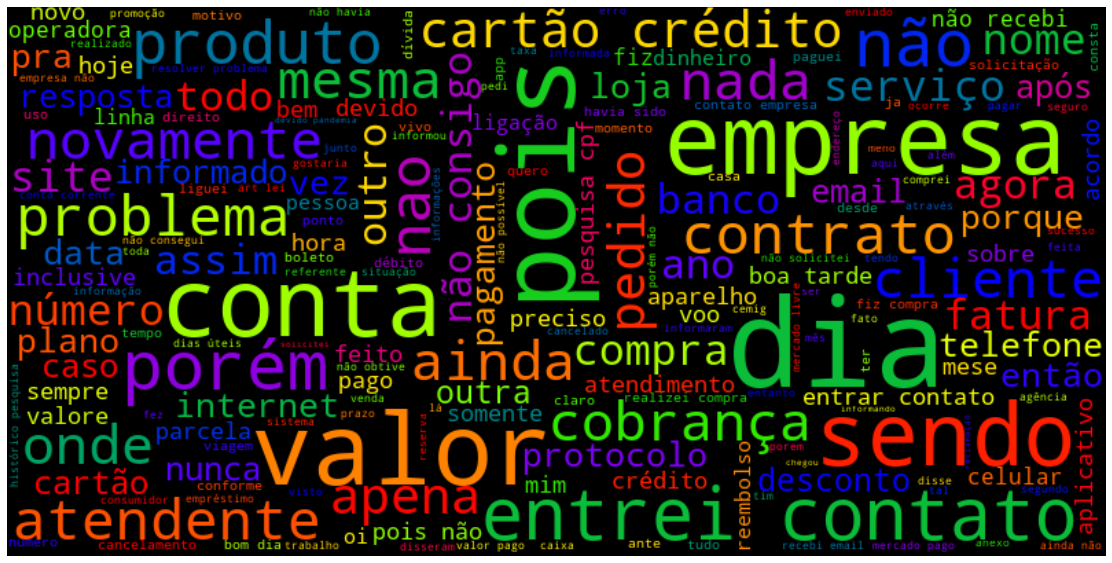

In [ ]:
# colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# colors: https://matplotlib.org/stable/gallery/color/named_colors.html

background_color = 'black'
cmap = 'prism'
str_tweets=word_cloud(data_relatos_processado, color = background_color, colormap = cmap, max_words = 200, size_X = 50, size_Y = 50)

#### Teste com Wordcloud com imagem de fundo

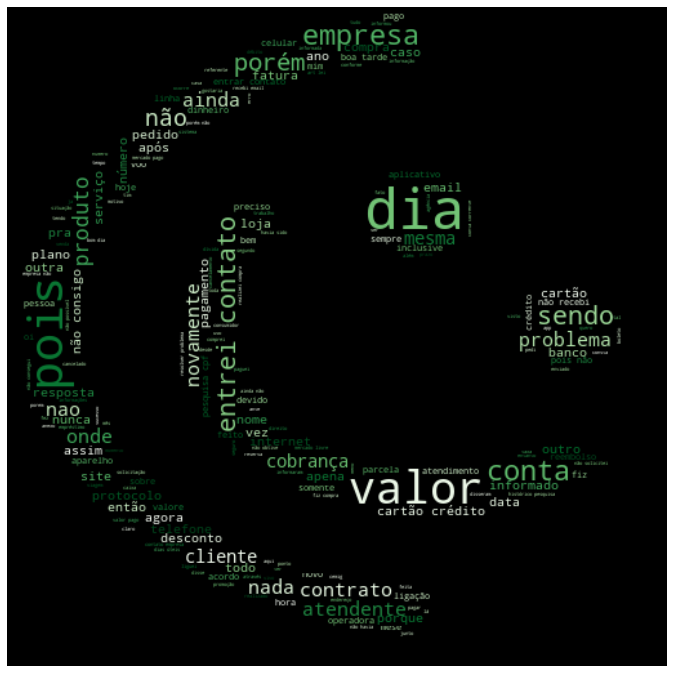

In [ ]:
img= 'Data-analysis/consumidor-gov-br/logo_consumidor.gov.br.png'
background_color='black'
cmap = 'Greens'
word_cloud_colored(data_relatos_processado, fig_img = img, color = background_color, colormap = cmap, size_X = 30, size_Y = 30)